In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
#!pip install netCDF4
from netCDF4 import Dataset as NetCDFFile
import random
import timeit
import pickle
from scipy import stats
import xarray as xr
import pandas as pd
import statistics
from scipy import interpolate
import os
import pytz, datetime
import multiprocessing as mp
import geopandas
#!pip install descartes
import descartes
from datetime import date

from datetime import datetime

import json
import openai
import os 

def load_api_key(secrets_file="/home/kaichiht/openai.json"):
    with open(secrets_file) as f:
        secrets = json.load(f)
    return secrets["OPENAI_API_KEY"]

# Set secret API key
# Typically, we'd use an environment variable (e.g., echo "export OPENAI_API_KEY='yourkey'" >> ~/.zshrc)
# However, using "internalConsole" in launch.json requires setting it in the code for compatibility with Hebrew
api_key = load_api_key()
openai.api_key = api_key

%reload_ext jupyter_ai

os.environ["OPENAI_API_KEY"]=openai.api_key

In [119]:
#!ls /work/DATA/Reanalysis/ERA5/t/
import netCDF4 as nc
d = {}
count = 0
for level in [1000, 925, 850, 700,500,250]:
    t  = nc.Dataset('/home/kaichiht/Colab/Course/2024_tropical-dynamics_data_process/t'+str(level)+'_mean.nc', 'r')
    z  = nc.Dataset('/home/kaichiht/Colab/Course/2024_tropical-dynamics_data_process/z'+str(level)+'_mean.nc', 'r')
    q  = nc.Dataset('/home/kaichiht/Colab/Course/2024_tropical-dynamics_data_process/q'+str(level)+'_mean.nc', 'r')
    psi  = nc.Dataset('/home/kaichiht/Colab/Course/2024_tropical-dynamics_data_process/psi_chi_'+str(level)+'_mean.nc', 'r')
    
    d["model{0}".format(count)] = np.array(t['t']).squeeze().astype(float) \
                                +(np.array(z['z']).squeeze().astype(float)+2.5e6*np.array(q['q']).squeeze().astype(float))/1004,'level='+str(level), \
                                 np.array(t['lat']), np.array(t['lon']), np.array(psi['velopot']).squeeze()
        
    count = count+1
    


/home/kaichiht/miniconda3/envs/jupyter_chatgpt/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'level'
  result = super().contourf(*args, **kwargs)


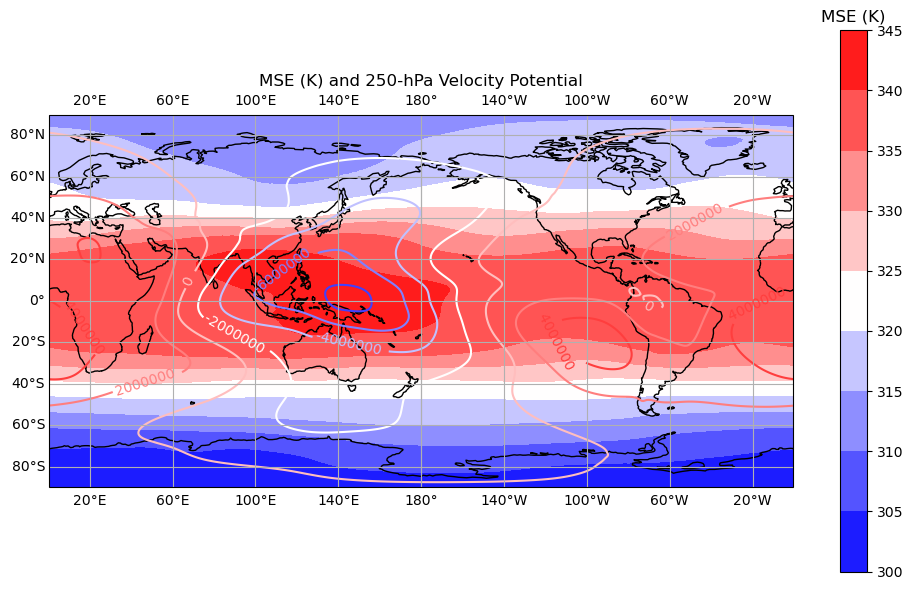

In [125]:
count = 5
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} "




xx, yy  = np.meshgrid(d["model{0}".format(count)][3],d["model{0}".format(count)][2])
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},figsize=(10, 6))
im2 =ax.contourf(xx-180,yy,d["model{0}".format(count)][0],cmap='bwr',level=np.arange(300,340,40))
CS  = ax.contour(xx-180,yy,d["model{0}".format(count)][4],cmap='bwr')
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(xlocs=range(-180,181,40), ylocs=range(-80,81,20),draw_labels=True)
ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
#cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im2,  orientation='vertical');
cbar.ax.set_title("MSE (K)")
plt.tight_layout()
plt.title('MSE (K) and 250-hPa Velocity Potential')
fig.savefig('MSE.png')


/home/kaichiht/miniconda3/envs/jupyter_chatgpt/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'level'
  result = super().contourf(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

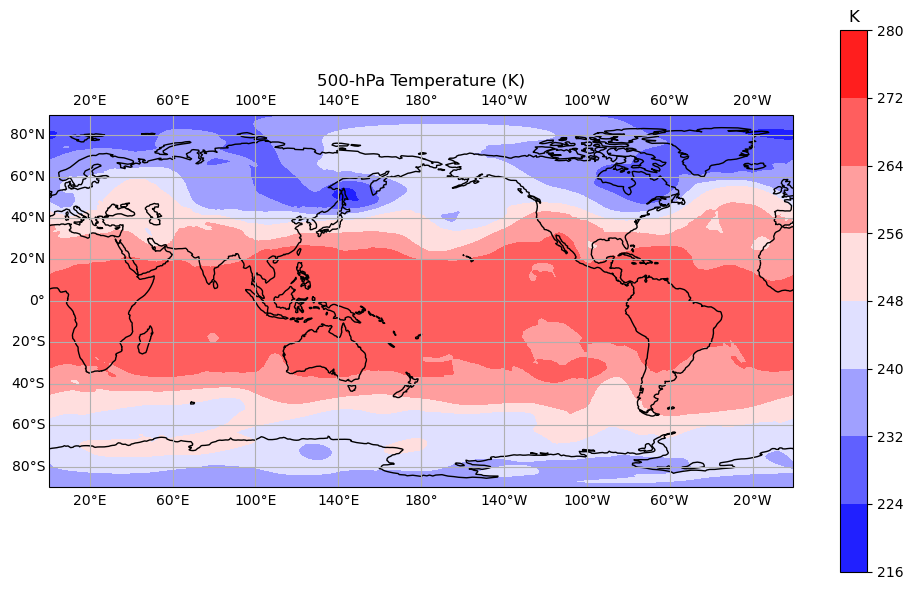

In [129]:
t  = nc.Dataset('/work/DATA/Reanalysis/ERA5/t/t500_1979.nc', 'r')
plt.figure()

xx, yy  = np.meshgrid(d["model{0}".format(count)][3],d["model{0}".format(count)][2])
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},figsize=(10, 6))
im2     = ax.contourf(xx-180,yy,np.array(t['t'])[10,:,:],cmap='bwr',level=np.arange(300,340,40))
#CS  = ax.contour(xx-180,yy,d["model{0}".format(count)][4],cmap='bwr')
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(xlocs=range(-180,181,40), ylocs=range(-80,81,20),draw_labels=True)
#ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
#cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im2,  orientation='vertical');
cbar.ax.set_title("K")
plt.tight_layout()
plt.title('500-hPa Temperature (K)')
fig.savefig('1979_1.png')

In [171]:

profile = np.zeros((6,10))

for i in range(10):
    count    = 0
    dim_lat  = random.sample(sorted(np.where(np.abs(d["model{0}".format(count)][2])<10)[0]),1)
    dim_lon  = random.sample(range(576),1)

    for count in range(6):
        profile[count,i] = np.array(d["model{0}".format(count)][0][dim_lat,dim_lon])
        count            = count+1

/tmp/ipykernel_3391854/3959123666.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  profile[count,i] = np.array(d["model{0}".format(count)][0][dim_lat,dim_lon])


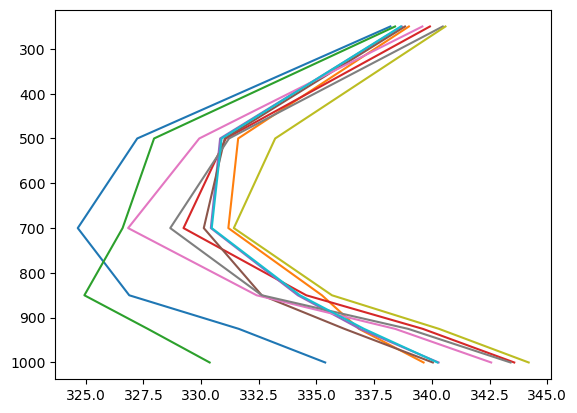

In [178]:
fig= plt.figure()
plt.plot(profile,np.array([1000, 925, 850, 700,500,250]))
plt.gca().invert_yaxis()
fig.savefig('random_MSE_profile.png')
#np.where(np.abs(d["model{0}".format(count)][2])<10)[0]

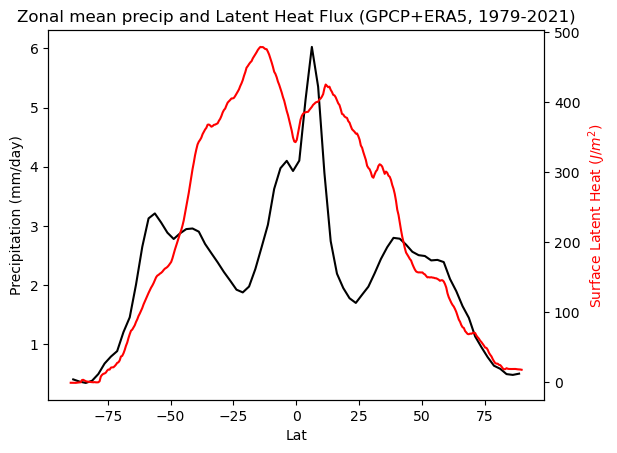

In [222]:
# zonal mean precipitation

precip       = nc.Dataset('/home/kaichiht/Colab/Course/2024_tropical-dynamics_data_process/precip_mean.nc', 'r')
zonal_precip = np.array(precip['precip']).mean(axis=(0,2))

LH           = nc.Dataset('/home/kaichiht/Colab/Course/2024_tropical-dynamics_data_process/LH_mean.nc', 'r')
zonal_LH     = np.array(LH['slhf']).mean(axis=(0,2))

#zonal_precip.shape
#fig= plt.figure()
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(np.array(precip['lat']),zonal_precip, 'k-')
ax2.plot(np.array(LH['lat']),-zonal_LH/1004, 'r-')

ax1.set_xlabel('Lat')
ax1.set_ylabel('Precipitation (mm/day)', color='k')
ax2.set_ylabel(r'Surface Latent Heat $(J/m^2)$', color='r')
plt.title('Zonal mean precip and Latent Heat Flux (GPCP+ERA5, 1979-2021)')
plt.show()


fig.savefig('zonal_mean_P.png')

In [234]:
%%ai chatgpt 
how many days are there between 1979 jan 1 and 2000 dec 31st? (including both dates)

```markdown
There are 7,830 days between 1979 Jan 1 and 2000 Dec 31.
```